In [46]:
import torch as torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [47]:
mnist_data = pd.read_csv("mnist_train.csv").values.tolist()
print("Read data, Number of images in the dataset: ", len(mnist_data))
# Convert mnist_data to a NumPy array
mnist_data = np.array(mnist_data)
num_samples = len(mnist_data)
num_train_samples = num_samples - 1000

X_train = mnist_data[:num_train_samples, 1:].astype(np.float32) / 255.0
Y_train = np.zeros((num_train_samples, 10), dtype=np.float32)
Y_train[np.arange(num_train_samples), mnist_data[:num_train_samples, 0].astype(int)] = 1.0

X_test = mnist_data[num_train_samples:, 1:].astype(np.float32) / 255.0
Y_test = np.zeros((1000, 10), dtype=np.float32)
Y_test[np.arange(1000), mnist_data[num_train_samples:, 0].astype(int)] = 1.0

Read data, Number of images in the dataset:  50558


In [48]:
#initialize
hidden_layer_size = 100
Weights1 = torch.randn(784, hidden_layer_size) * 0.01
Bias1 = torch.randn(1, hidden_layer_size)
Weights2 = torch.randn(hidden_layer_size, 10) * 0.01
Bias2 = torch.randn(1, 10)
X_train = torch.from_numpy(X_train)
Y_train = torch.from_numpy(Y_train)

def relu(x): return torch.max(torch.zeros(x.size()), x)
def softmax(x): return torch.exp(x) / torch.sum(torch.exp(x))
def relu_deriv(x): return torch.where(x > 0, torch.ones_like(x), torch.zeros_like(x))
def softmax_deriv(x):
    exp_x = torch.exp(x)
    return exp_x / torch.sum(exp_x, dim=1, keepdim=True) * (1 - exp_x / torch.sum(exp_x, dim=1, keepdim=True))

lr = 0.3
mini_batch_size = 8
iterations = 800

listLoss = []
for i in range(iterations):
    #get a random mini-batch
    random_indices = torch.randperm(X_train.shape[0])
    random_indices = random_indices[:mini_batch_size]
    X_train_mini_batch = X_train[random_indices]
    Y_train_mini_batch = Y_train[random_indices]

    #forward
    forwardFirstLayer = torch.matmul(X_train_mini_batch, Weights1) + Bias1
    forwardFirstLayer = relu(forwardFirstLayer)
    forwardSecondLayer = torch.matmul(forwardFirstLayer, Weights2) + Bias2
    forwardSecondLayer = relu(forwardSecondLayer)

    #calculate the -logloss
    log_probs = torch.log_softmax(forwardSecondLayer, dim=1)
    logloss = -torch.sum(log_probs * Y_train_mini_batch) / X_train_mini_batch.shape[0]

    #backward | calculate the gradients
    dlogloss = (forwardSecondLayer - Y_train_mini_batch) * softmax_deriv(forwardSecondLayer)
    dWeights2 = torch.matmul(forwardFirstLayer.T, dlogloss) / X_train_mini_batch.shape[0]
    dBias2 = torch.sum(dlogloss, 0) / X_train_mini_batch.shape[0]
    dforwardFirstLayer = torch.matmul(dlogloss, Weights2.T) * relu_deriv(forwardFirstLayer)
    dWeights1 = torch.matmul(X_train_mini_batch.T, dforwardFirstLayer) / X_train_mini_batch.shape[0]
    dBias1 = torch.sum(dforwardFirstLayer, 0) / X_train_mini_batch.shape[0]

    #update the weights
    Weights1 = Weights1 - lr * dWeights1
    Bias1 = Bias1 - lr * dBias1
    Weights2 = Weights2 - lr * dWeights2
    Bias2 = Bias2 - lr * dBias2

    listLoss.append(logloss)
    if i % 100 == 0:
        print("Iteration: ", i)
        print("Loss: ", logloss)

#test on 1000 test images
correct = 0
for n in range(0, 1000):
    forwardFirstLayer = torch.matmul(torch.from_numpy(X_test)[n], Weights1) + Bias1
    forwardFirstLayer = relu(forwardFirstLayer)
    forwardSecondLayer = torch.matmul(forwardFirstLayer, Weights2) + Bias2
    if torch.argmax(forwardSecondLayer) == torch.argmax(torch.from_numpy(Y_test)[n]): correct += 1
print("Test Accuracy:", (correct / 10))

Iteration:  0
Loss:  tensor(2.4024)
Iteration:  100
Loss:  tensor(2.1663)
Iteration:  200
Loss:  tensor(2.1204)
Iteration:  300
Loss:  tensor(1.8849)
Iteration:  400
Loss:  tensor(1.6606)
Iteration:  500
Loss:  tensor(1.6976)
Iteration:  600
Loss:  tensor(1.6846)
Iteration:  700
Loss:  tensor(1.7818)
Test Accuracy: 84.4


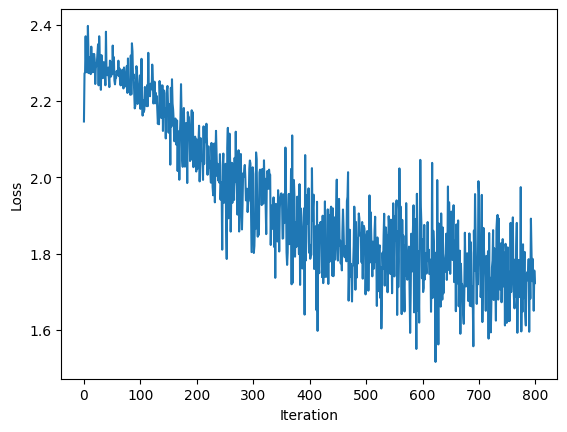

In [10]:
#plot the loss
plt.plot(listLoss)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()